# Understanding the difference between traditional model and using full luxury Bayes

In [60]:
import arviz as az
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pymc as pm
import re
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [61]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [62]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [63]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'


<IPython.core.display.Javascript object>

In [138]:
df_howell = pd.read_csv(DATA_DIR + "Howell1.csv", sep=";", header=0)
# limit to adults
df_howell_ad = df_howell[df_howell['age'] >= 18].copy()
df_howell_ad.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

In [139]:
heights = df_howell_ad['height'].values
h_bar = df_howell_ad['height'].mean()
s_index = df_howell_ad['male'].values
weights = df_howell_ad['weight'].values

<IPython.core.display.Javascript object>

# Slide 26: total causal effect of S on W

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{S[i]}$$
$$ \alpha_j \sim \text{Normal}(60, 10) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [141]:
with pm.Model() as m_SW:
    
    # priors
    a = pm.Normal("a", 60, 10, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    
    mu = a[s_index]                                  # linear model    
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # posterior
    idata_m_SW = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>

In [143]:
az.summary(idata_m_SW)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],41.844,0.407,41.170,42.453,0.005,0.004,5937.0,3273.0,1.0
a[1],48.617,0.438,47.911,49.281,0.006,0.004,5692.0,3262.0,1.0
sigma,5.527,0.215,5.164,5.842,0.003,0.002,5624.0,2968.0,1.0


<IPython.core.display.Javascript object>

## Slide 28

In [144]:
idata_m_SW_df = idata_m_SW.to_dataframe()
idata_m_SW_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, sigma)","(log_likelihood, W[0], 0)","(log_likelihood, W[100], 100)","(log_likelihood, W[101], 101)","(log_likelihood, W[102], 102)","(log_likelihood, W[103], 103)",...,"(sample_stats, step_size)","(sample_stats, lp)","(sample_stats, perf_counter_start)","(sample_stats, index_in_trajectory)","(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, acceptance_rate)","(sample_stats, smallest_eigval)","(sample_stats, energy_error)","(sample_stats, largest_eigval)"
0,0,0,41.374143,49.565146,5.568575,-2.684870,-2.639546,-2.769404,-3.783564,-4.312207,...,1.371448,-1112.181430,331216.710104,-2,False,0.713855,0.558588,NaN,0.461278,NaN
1,0,1,41.190155,48.702179,5.690652,-2.669627,-2.660223,-2.769616,-3.804998,-4.545945,...,1.371448,-1110.733180,331216.711151,2,False,1.547807,0.654010,NaN,-0.350832,NaN
2,0,2,42.566289,48.850167,5.830054,-2.697407,-2.682893,-2.925362,-3.453855,-4.433103,...,1.371448,-1111.819459,331216.711867,2,False,0.309516,0.739602,NaN,0.303745,NaN
3,0,3,41.445843,47.671761,5.343883,-2.595306,-2.630673,-2.746975,-3.819812,-5.153687,...,1.371448,-1112.333332,331216.712541,2,False,-0.224085,0.958355,NaN,0.133457,NaN
4,0,4,42.214386,47.934488,5.476165,-2.619541,-2.642045,-2.849548,-3.581290,-4.951253,...,1.371448,-1110.709363,331216.713213,-1,False,-0.594247,1.000000,NaN,-0.524421,NaN


<IPython.core.display.Javascript object>

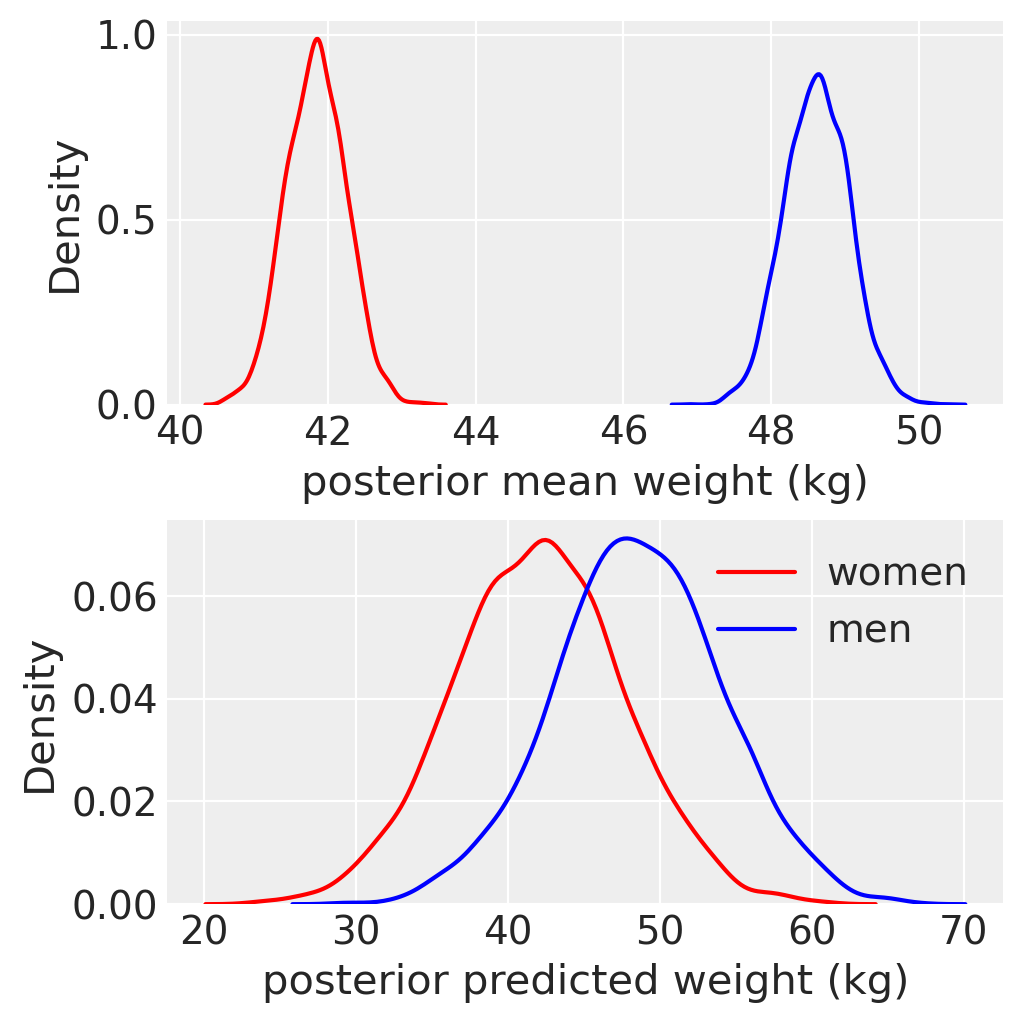

<IPython.core.display.Javascript object>

In [161]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(5,5))

# Plot of contrast using distribution of mean only  ---------
sns.kdeplot(idata_m_SW_df[('posterior', 'a[0]', 0)], color='red', ax=ax0)
sns.kdeplot(idata_m_SW_df[('posterior', 'a[1]', 1)], color='blue', ax=ax0)
ax0.set(xlabel='posterior mean weight (kg)')

# # Plot of contrast using full posterior distribution ---------
W0 = stats.norm.rvs(
    loc=idata_m_SW_df[('posterior', 'a[0]', 0)],
    scale=idata_m_SW_df[('posterior', 'sigma')],
    )

W1 = stats.norm.rvs(
    loc=idata_m_SW_df[('posterior', 'a[1]', 1)],
    scale=idata_m_SW_df[('posterior', 'sigma')],
    )

sns.kdeplot(W0, color='red', label='women', ax=ax1)
sns.kdeplot(W1, color='blue', label='men', ax=ax1)
ax1.set(xlabel='posterior predicted weight (kg)')
ax1.legend()


# Slide 39: Running the model on 

"One stat model for each estimand"

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{S[i]} + \beta_{S[i]}(H_i - \bar{H}) $$
$$ \alpha_j \sim \text{Normal}(60, 10) $$
$$ \beta_j \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [140]:
with pm.Model() as m_SHW:
    
    # priors
    a = pm.Normal("a", 60, 10, shape=2)
    b = pm.Lognormal("b", 0, 1, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    
    mu = a[s_index] + b[s_index]*(heights-h_bar)  # linear model    
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # posterior
    idata_m_SHW = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


<IPython.core.display.Javascript object>

# Full Luxury Bayes model on slide 44

One simulation for each estimand

In [ ]:

with pm.Model() as m_SHW_full:

    # weight -----------
    a = pm.Normal("a", 60, 10, shape=2)
    b = pm.Lognormal("b", 0, 1, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a[s_index] + b[s_index]*(heights-h_bar)  # linear model
    W = pm.Normal("W", mu, sigma, observed=weights)  # likelihood

    # height -----------
    h = pm.Normal("h", 160, 10, shape=2)
    tau = pm.Uniform("tau", 0, 10)
    nu = h[s_index]                                # linear model
    H = pm.Normal("H", nu, tau, observed=heights)  # likelihood

    # posterior
    idata_m_SHW_full = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=True)

    # posterior predictions
    #post_pred_m_SHW_full = pm.sample_posterior_predictive(trace=idata_m_SHW_full, samples=100)

In [66]:
az.summary(idata_m_SHW_full)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.167,0.454,44.479,45.918,0.007,0.005,4904.0,2877.0,1.0
a[1],45.144,0.469,44.398,45.886,0.007,0.005,4103.0,3178.0,1.0
h[0],149.506,0.421,148.792,150.131,0.006,0.004,5147.0,2731.0,1.0
h[1],160.371,0.433,159.718,161.100,0.006,0.004,5995.0,2917.0,1.0
b[0],0.644,0.063,0.546,0.745,0.001,0.001,4841.0,3128.0,1.0
b[1],0.609,0.055,0.522,0.699,0.001,0.001,4012.0,3079.0,1.0
sigma,4.282,0.165,4.020,4.539,0.002,0.002,5819.0,2943.0,1.0
tau,5.574,0.215,5.247,5.930,0.003,0.002,5754.0,2535.0,1.0


<IPython.core.display.Javascript object>

In [67]:
idata_m_SHW_full_df = idata_m_SHW_full.to_dataframe()
idata_m_SHW_full_df.head()


,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, h[0], 0)","(posterior, h[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, sigma)","(posterior, tau)",...,"(sample_stats, step_size)","(sample_stats, lp)","(sample_stats, perf_counter_start)","(sample_stats, index_in_trajectory)","(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, acceptance_rate)","(sample_stats, smallest_eigval)","(sample_stats, energy_error)","(sample_stats, largest_eigval)"
0,0,0,44.362499,45.562718,149.734371,159.945487,0.547245,0.481476,4.151993,5.554142,...,0.57743,-2100.793483,263810.942634,5,False,0.645958,0.740684,NaN,0.268362,NaN
1,0,1,45.915887,44.405779,149.290088,160.535733,0.771452,0.638038,4.392135,5.563645,...,0.57743,-2098.414436,263810.944446,-5,False,-0.546761,1.000000,NaN,-0.134698,NaN
2,0,2,44.593644,45.437663,149.281824,159.364576,0.625358,0.674925,4.290460,5.556995,...,0.57743,-2101.280383,263810.946296,-4,False,0.722129,0.736339,NaN,0.722129,NaN
3,0,3,45.068269,45.172996,149.570846,161.086906,0.659807,0.721705,4.326027,5.584373,...,0.57743,-2100.072189,263810.948483,5,False,1.133078,0.749614,NaN,-0.132609,NaN
4,0,4,45.341266,45.489250,150.323684,159.535289,0.647195,0.598159,4.238301,5.629862,...,0.57743,-2098.939615,263810.951152,5,False,-0.706757,0.924437,NaN,-0.706757,NaN


<IPython.core.display.Javascript object>

In [76]:
n = 10**4

# simulate W for S=0
H_S0 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[('posterior', 'h[0]', 0)],
    scale=idata_m_SHW_full_df[('posterior', 'tau')],
    # size=n   (*see note below) 
    )

W_S0 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[('posterior', 'a[0]', 0)] + \
        idata_m_SHW_full_df[('posterior', 'b[0]', 0)] * (H_S0-h_bar),
    scale=idata_m_SHW_full_df[('posterior', 'sigma')],
    )

# simulate W for S=1
H_S1 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[('posterior', 'h[1]', 1)],
    scale=idata_m_SHW_full_df[('posterior', 'tau')],
    # size=n   (*see note below) 
    )

W_S1 = stats.norm.rvs(
    loc=idata_m_SHW_full_df[('posterior', 'a[1]', 1)] + \
        idata_m_SHW_full_df[('posterior', 'b[1]', 1)] * (H_S1-h_bar),
    scale=idata_m_SHW_full_df[('posterior', 'sigma')],
    )

# compute contrast using full posterior distribution 
W_do_S = W_S1 - W_S0


# *unlike in R, size has to be the same as the length of the vectors

<IPython.core.display.Javascript object>

In slides 47 and 48, he shows the posterior mean weight contrast in the left plot. However, the posterior mean weight are not explicitly calculated. But this is a reminder that the means of each group are themselves distributions, since they are the output of the alpha and beta parameters which are distributions. We get the posterior mean contrasts by taking the difference of these distributions. (Note that his plot appears more narrow. It's not clear to me why.)

It's also worth pointing out that the posterior mean weight contrast is using the posterior directly (not posterior predictive).

The plot on the right is using the posterior predictive (it's simulating observations) since we're using random draws and not using the posterior.

In [129]:
# compute contrast using mean only
W_S0_mean = idata_m_SHW_full_df[('posterior', 'a[0]', 0)] + \
        idata_m_SHW_full_df[('posterior', 'b[0]', 0)] * (H_S0-h_bar)

W_S1_mean = idata_m_SHW_full_df[('posterior', 'a[1]', 1)] + \
        idata_m_SHW_full_df[('posterior', 'b[1]', 1)] * (H_S1-h_bar)

W_do_S_mean = W_S1_mean - W_S0_mean

<IPython.core.display.Javascript object>

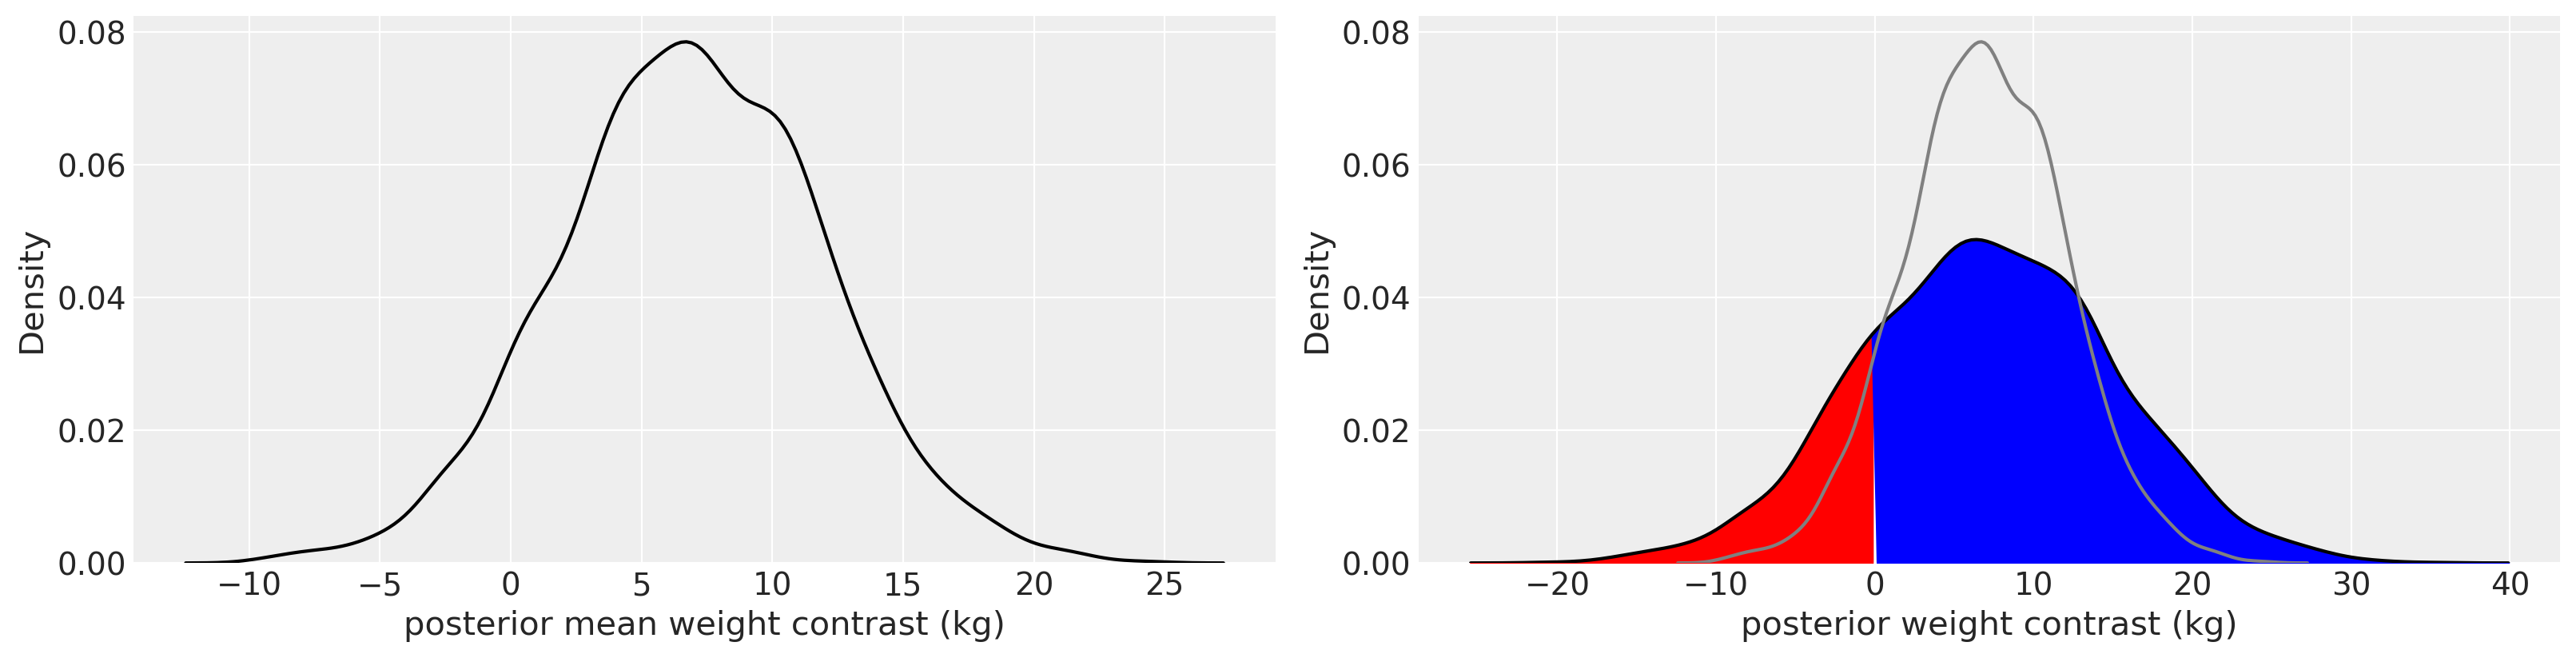

<IPython.core.display.Javascript object>

In [137]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,4))

# Plot of contrast using distribution of mean only  ---------
sns.kdeplot(W_do_S_mean, color='black', ax=ax0)
ax0.set(xlabel='posterior mean weight contrast (kg)')

# Plot of contrast using full posterior distribution ---------
ax1 = sns.kdeplot(W_do_S, color='black') #, ax=ax0)
sns.kdeplot(W_do_S_mean, color='gray', ax=ax1)

ax1.set(xlabel='posterior weight contrast (kg)')
# Fill colors
kde_x, kde_y = ax1.lines[0].get_data()   
ax1.fill_between(kde_x, kde_y, where= kde_x < 0, color='red', interpolate=True)
ax1.fill_between(kde_x, kde_y, where= kde_x > 0, color='blue', interpolate=True)


# Fill between from this link
# https://stackoverflow.com/questions/46685453/how-to-fill-with-a-different-color-an-area-in-seaborn-distplot
